# Figure 2
Cortical neurons encode history information with exponential decay

In [1]:
%load_ext autoreload

## General import functions

In [25]:
%reset -f
import sys
from os.path import dirname, join as pjoin
from os import listdir
sys.path.append('C:\\jupyter_notebooks\\Danskin_SciAdv_2023\\py_code') # set local directory
import numpy as np
import pickle
import random
import xarray as xr
import pandas as pd

import h5py
import scipy.io as sio
from scipy import stats
import statsmodels as sm # import statsmodels.api as sm
from scipy.optimize import minimize, basinhopping, curve_fit
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, trange

In [26]:
## Directories
%autoreload
import bdanskin as BD 

project_dir = 'C:\\jupyter_notebooks\\Danskin_SciAdv_2023' # local directory
imaging_dir = pjoin(project_dir, 'hattori_datasets_xarray')
cellfits_dir = pjoin(project_dir, 'hattori_datasets_xarray_cellfits')
behavior_dir = pjoin(project_dir, 'hattori_datasets_behavior')

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
fig_save_dir = 'ms_figures_230623'

## General plotting functions

In [28]:
plt_colors = BD.plt_color_dir()
def sem(y):
    if len(np.shape(y))==1:
        return np.nanstd(y)/np.sqrt(len(y)-1)
    else:
        n,_ = np.shape(y)
        return np.nanstd(y,0)/np.sqrt(n-1)

def plt_remove_spines(ax):
    if len(np.shape(ax))>1:
        ax_y, ax_x = np.shape(ax)
        for xx in range(ax_x):
            for yy in range(ax_y):
                ax[yy,xx].spines['top'].set_visible(False)
                ax[yy,xx].spines['right'].set_visible(False)
    else:
        for xx in range(len(ax)):
            ax[xx].spines['top'].set_visible(False)
            ax[xx].spines['right'].set_visible(False)

def stats_compare(y):
    if np.nanmean(y)>0:
        pos_neg = 1
    else:
        pos_neg = -1
        
    _,pnorm = stats.normaltest(y)
    if pnorm<0.05:
        h_norm = 0
        _, pval = stats.wilcoxon(y)
        print('wilcoxon')
    else:
        h_norm = 1
        _, pval = stats.ttest_1samp(y,0.0)
        print('ttest')
        
    h_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        h_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        h_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        h_lvl = 3
    elif (pval<0.0001):
        h_lvl = 4
    return pval, h_lvl, h_norm, pos_neg

def sig_text(pval):
    sig_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        sig_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        sig_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        sig_lvl = 3
    elif (pval<0.0001):
        sig_lvl = 4

    if sig_lvl==4:
        txt_out = '****'
    elif sig_lvl==3:
        txt_out = '***'  
    elif sig_lvl==2:
        txt_out = '**'      
    elif sig_lvl==1:
        txt_out = '*'
    else:
        txt_out = 'n.s.'
    return txt_out

def add_sig_plt(ax,x_ind,y_ind,font_size,pval,sig_lvl,pos_neg):
    plt_clr = 'k'
    if pos_neg==1:
        plt_clr = 'r'
        
    if sig_lvl==-1:    # catch for mixedeffects that have no sig lvl
        sig_lvl = 0
        if (pval<0.05) & (pval>=0.01):
            sig_lvl = 1
        elif (pval<0.01) & (pval>=0.001):
            sig_lvl = 2
        elif (pval<0.001) & (pval>=0.0001):
            sig_lvl = 3
        elif (pval<0.0001):
            sig_lvl = 4

    if sig_lvl==4:
        ax.text(x_ind,y_ind,'****',color=plt_clr,fontsize = font_size, transform = ax.transAxes)
    if sig_lvl==3:
        ax.text(x_ind,y_ind,'***',color=plt_clr,fontsize = font_size, transform = ax.transAxes)  
    if sig_lvl==2:
        ax.text(x_ind,y_ind,'**',color=plt_clr,fontsize = font_size, transform = ax.transAxes)      
    if sig_lvl==1:
        ax.text(x_ind,y_ind,'*',color=plt_clr,fontsize = font_size, transform = ax.transAxes)

## Specific plotting functions

### Extraction functions

In [29]:
def extract_values(xr, mdl_type, cell_select, param_name):
    val_vec = xr.sel(mdl_type=mdl_type,cell=cell_select)[param_name].values
    return val_vec

In [30]:
# extraction functions for Rp1 cell selection
def parameter_load_session(session, crit_type, mdl_name, param_name): # For each session
    # load cv xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    cv_xarray = xr.open_dataset(save_filename)

    # load havles xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    halves_xarray = xr.open_dataset(save_filename)
    
    # get old Rp1 cell selection
    load_filename = pjoin(cellfits_dir,'ready_cellfits_RCp1','RCp1_2s_{}.nc'.format(session))
    rp1_xarray = xr.open_dataset(load_filename)
    rp1_xarray = rp1_xarray.sel(shuffle=0).drop(labels='shuffle')


    if crit_type==0:
        cell_select = (rp1_xarray.p_beta_RCp1.values)<0.05
    else:
        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
    
    # get parameter of interest
    param_sig = halves_xarray.sel(half=0, cell=cell_select, mdl_type=mdl_name)[param_name].values
    return param_sig

def get_lik_dif_session(session, crit_type, mdl_1, mdl_2): # For each session
    param_name = 'cv_mean_norm_loglik'
    # load cv xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    cv_xarray = xr.open_dataset(save_filename)
    
    # load havles xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    halves_xarray = xr.open_dataset(save_filename)
    
    # get old Rp1 cell selection
    load_filename = pjoin(cellfits_dir,'ready_cellfits_RCp1','RCp1_2s_{}.nc'.format(session))
    rp1_xarray = xr.open_dataset(load_filename)
    rp1_xarray = rp1_xarray.sel(shuffle=0).drop(labels='shuffle')
    
    if crit_type==0:
        cell_select = (rp1_xarray.p_beta_RCp1.values)<0.05
    else:
        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
    
    # get parameter of interest
    fit_mdl_1 = cv_xarray.sel(cell=cell_select, mdl_type=mdl_1)[param_name].values
    fit_mdl_2 = cv_xarray.sel(cell=cell_select, mdl_type=mdl_2)[param_name].values
    return fit_mdl_1 - fit_mdl_2

In [31]:
def get_cell_select(cv_xarray, halves_xarray, crit_type):
    ll_thr = 0 # 1e-3
    if crit_type==0: # Old Rp1
        rp1_p_val_cv = cv_xarray.sel(mdl_type='Rp1')['cv_gmean_p_beta_RC'].values
        sig_cell = (rp1_p_val_cv<0.05)
    elif crit_type==1: # FDR Rp1
        rp1_p_val_cv = cv_xarray.sel(mdl_type='Rp1')['cv_gmean_p_beta_RC'].values
        _,fdr_rp1_cv,_,_ = sm.stats.multitest.multipletests(rp1_p_val_cv, alpha=0.05,method='fdr_bh')
        sig_cell = (fdr_rp1_cv<0.05)
    elif crit_type==2: # Model fit Rp1
        rp1_p_val_cv = cv_xarray.sel(mdl_type='Rp1')['cv_gmean_p_beta_RC'].values
        rp1_d_null_cv = (cv_xarray.sel(mdl_type='Rp1')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        sig_cell = ((rp1_p_val_cv<0.05) & (rp1_d_null_cv>ll_thr))
    elif crit_type==3: # AND RC
        rc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_RC'].values
        rc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_RC'].values
        sig_cell = ( (rc_p_val_1<0.05) & (rc_p_val_2<0.05) & 
                     (rc_tau_1<99) & (rc_tau_1>0.01) & (rc_tau_2<99) & (rc_tau_2>0.01) )
    elif crit_type==4: # AND UC
        uc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_UC'].values
        uc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_UC'].values
        sig_cell = ( (uc_p_val_1<0.05) & (uc_p_val_2<0.05) & 
                     (uc_tau_1<99) & (uc_tau_1>0.01) & (uc_tau_2<99) & (uc_tau_2>0.01) )
    elif crit_type==5: # Model fit RC
        rc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_RC'].values
        _,fdr_rc_cv,_,_ = sm.stats.multitest.multipletests(rc_p_val_cv, alpha=0.05,method='fdr_bh')
        ru_d_null_cv = (cv_xarray.sel(mdl_type='exp_r')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        rc_tau_0 = halves_xarray.sel(half=0, mdl_type='exp_r')['tau_RC'].values
        sig_cell = ( (ru_d_null_cv>ll_thr) & (fdr_rc_cv<0.05) &
                     (rc_tau_0<99) & (rc_tau_0>0.01) )
    elif crit_type==6: # Model fit UC
        uc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_UC'].values
        _,fdr_uc_cv,_,_ = sm.stats.multitest.multipletests(uc_p_val_cv, alpha=0.05,method='fdr_bh')
        uc_d_null_cv = (cv_xarray.sel(mdl_type='exp_r')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        uc_tau_0 = halves_xarray.sel(half=0, mdl_type='exp_r')['tau_RC'].values
        sig_cell = ( (uc_d_null_cv>ll_thr) & (fdr_uc_cv<0.05) &
                     (uc_tau_0<99) & (uc_tau_0>0.01) )
    elif crit_type==7: # AND RC, UC
        rc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_RC'].values
        rc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_RC'].values

        uc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_u')['tau_UC'].values
        uc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_UC'].values
        sig_cell = ( (rc_p_val_1<0.05) & (rc_p_val_2<0.05) & (uc_p_val_1<0.05) & (uc_p_val_2<0.05) & 
                     (rc_tau_1<99) & (rc_tau_1>0.01) & (rc_tau_2<99) & (rc_tau_2>0.01)  &
                     (uc_tau_1<99) & (uc_tau_1>0.01) & (uc_tau_2<99) & (uc_tau_2>0.01) )
        
    elif crit_type==8: # Model fit RC, UC
        rc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_RC'].values
        uc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_UC'].values
        _,fdr_rc_cv,_,_ = sm.stats.multitest.multipletests(rc_p_val_cv, alpha=0.05,method='fdr_bh')
        _,fdr_uc_cv,_,_ = sm.stats.multitest.multipletests(uc_p_val_cv, alpha=0.05,method='fdr_bh')
        
        ru_d_null_cv = (cv_xarray.sel(mdl_type='exp_r')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        sig_cell = (ru_d_null_cv>ll_thr) & ((fdr_rc_cv<0.05) | (fdr_uc_cv<0.05))
    else:
        sig_cell = np.ones(len(halves_xarray.cell)).astype(bool)
        
    return sig_cell    

In [33]:
def get_sessions_pd(area, crit_type):
    mdl_name = 'exp_r'
    # param_name = 'tau_RC' # 'tau_UC'
    sessions_all = BD.get_sessions(area)
    output_all = pd.DataFrame([])
    for session in sessions_all:
        # load cv xarray
        load_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(session))
        cv_xarray = xr.open_dataset(load_filename)

        # load havles xarray
        load_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(session))
        halves_xarray = xr.open_dataset(load_filename)

        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
        
        if sum(cell_select)>0:
            # get parameter of interest
            processed_xarray = halves_xarray.sel(half=0, cell=cell_select, mdl_type=mdl_name)
            out_pd = processed_xarray.to_dataframe()[['snr','beta_RC','tau_RC','beta_UC','tau_UC','p_beta_RC','p_beta_UC']]

            output_all = output_all.append(out_pd,ignore_index=True)
    return output_all

### Cell fraction, correlation

In [34]:
def calc_cell_frac(area, crit_type):
    sessions_all = BD.get_sessions(area)
    cell_frac = np.array([])
    for ss in range(len(sessions_all)):
        # load cv xarray
        save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
        cv_xarray = xr.open_dataset(save_filename)

        # load havles xarray
        save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
        halves_xarray = xr.open_dataset(save_filename)

        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
        cell_frac = np.append(cell_frac, np.mean(cell_select))
    return cell_frac


### Delta loglik

In [35]:
def delta_loglik_func(temp_ds_1,temp_ds_2,mdl_type_1,mdl_type_2,n_hist):
    y_out = (temp_ds_1.loc[((temp_ds_1['mdl_type']==mdl_type_1) & 
                           (temp_ds_1['mdl_hist']==n_hist)), 'CV_mean_norm_loglik'] -
             temp_ds_2.loc[((temp_ds_2['mdl_type']==mdl_type_2) & 
                           (temp_ds_2['mdl_hist']==n_hist)), 'CV_mean_norm_loglik']).values
    return y_out

### box plots

In [36]:
def plot_colored_boxplot(ax,data_vec,x_pos,tmp_c):
    ax.boxplot(data_vec, positions=[x_pos], widths=.4, notch=False, showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='none',color=tmp_c,linewidth=1.5),
           capprops=dict(color=tmp_c,linewidth=1.5),
           whiskerprops=dict(color=tmp_c,linewidth=1.5),
           medianprops=dict(color=tmp_c,linewidth=1.5),
            )
def plot_bxplt(ax, y, x, clr):
    ax.boxplot([y], positions=[x], widths=0.35, notch=False,showfliers=False,
               patch_artist=True,
               boxprops=dict(facecolor='none',color=clr,linewidth=1.0),
               capprops=dict(color=clr,linewidth=1.0),
               whiskerprops=dict(color=clr,linewidth=1.0),
               medianprops=dict(color=clr,linewidth=1.0))

## Example cells (ready- and choice-aligned)

### Load session data, coarsen

In [37]:
sessions_all = BD.get_sessions('RSC')
ss = 10
save_filename = pjoin(imaging_dir,'{}_readyaligned.nc'.format(sessions_all[ss]))
ds_ready = xr.open_dataset(save_filename)
ds_ready_windowed = ds_ready.sel(frame=slice(-54,62)).z_spks.coarsen(frame=9,boundary='trim').mean() 
# ds_ready_windowed.frame

In [38]:
save_filename = pjoin(imaging_dir,'{}_choicealigned.nc'.format(sessions_all[ss]))
x_offset = 90
ds_choice = xr.open_dataset(save_filename)
ds_choice.sel(frame=slice(-15,120))
ds_choice_windowed = ds_choice.sel(frame=slice(-18,62)).z_spks.coarsen(frame=9,boundary='trim').mean() 
ds_choice_windowed['frame'] = ds_choice_windowed.frame+x_offset # to align on axes with gap
# ds_choice_windowed.frame

In [40]:
a = np.array(ds_ready.a)
R = np.array(ds_ready.R)
n_back = 10
# Choice metrics
choice_trials = (a==1)|(a==2)
a_hist,R_hist,_ = BD.prepare_hist_matrix(a,R,n_back)
rc_hist = a_hist*R_hist

### [Plt] Example cell 1

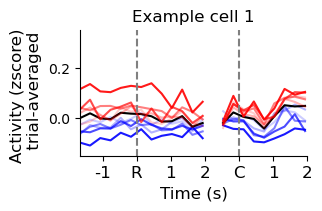

In [149]:
f,ax = plt.subplots(1,1, figsize = [3.5,2], tight_layout=False)
cell_id = 417; y_lim = [-.15,.35]; title_txt = 'Example cell 1'
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=1, left', alpha=0.9)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=2, left', alpha=0.7)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=3, left', alpha=0.5)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=4, left', alpha=0.3)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=5, left', alpha=0.2)
ds_ready_windowed.isel(cell=cell_id).mean(dim='trial').plot(ax=ax,c='k',label='all trials')
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=1, right', alpha=0.9)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=2, right', alpha=0.7)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=3, right', alpha=0.5)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=4, right', alpha=0.3)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=5, right', alpha=0.2)

(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=1, left', alpha=0.9)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=2, left', alpha=0.7)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=3, left', alpha=0.5)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=4, left', alpha=0.3)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=5, left', alpha=0.2)
ds_choice_windowed.isel(cell=cell_id).mean(dim='trial').plot(ax=ax,c='k',label='all trials')
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=1, right', alpha=0.9)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=2, right', alpha=0.7)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=3, right', alpha=0.5)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=4, right', alpha=0.3)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=5, right', alpha=0.2)

ax.plot([0,0],[-1,1],'--',c='gray')
ax.plot([x_offset,x_offset],[-1,1],'--',c='gray')
ax.set_xlim([-50,150])
ax.set_ylim(y_lim)
ax.set_xticks([-30,0,30,60,x_offset,x_offset+30,x_offset+60])
ax.set_xticklabels([-1,'R',1,2,'C',1,2],fontsize=12)
ax.set_xlabel('Time (s)',fontsize=12)
ax.set_ylabel('Activity (zscore) \n trial-averaged',fontsize=12)
ax.set_title(title_txt,fontsize=12)
# ax.legend(loc='lower left',bbox_to_anchor = (0,1), ncol=4, frameon=False)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
f.subplots_adjust(left=.25, bottom=.25, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'2_cell','cell_example_{}.png'.format(cell_id)))
# f.savefig(pjoin(fig_save_dir,'2_cell','cell_example_{}.svg'.format(cell_id)))

### [Plt] Example cell 2

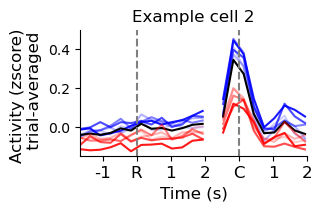

In [150]:
f,ax = plt.subplots(1,1, figsize = [3.5,2], tight_layout=False)
cell_id = 122; y_lim = [-.15,.5]; title_txt = 'Example cell 2'
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=1, left', alpha=0.9)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=2, left', alpha=0.7)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=3, left', alpha=0.5)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=4, left', alpha=0.3)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=5, left', alpha=0.2)
ds_ready_windowed.isel(cell=cell_id).mean(dim='trial').plot(ax=ax,c='k',label='all trials')
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=1, right', alpha=0.9)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=2, right', alpha=0.7)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=3, right', alpha=0.5)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=4, right', alpha=0.3)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=5, right', alpha=0.2)

(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=1, left', alpha=0.9)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=2, left', alpha=0.7)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=3, left', alpha=0.5)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=4, left', alpha=0.3)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=5, left', alpha=0.2)
ds_choice_windowed.isel(cell=cell_id).mean(dim='trial').plot(ax=ax,c='k',label='all trials')
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=1, right', alpha=0.9)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=2, right', alpha=0.7)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=3, right', alpha=0.5)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=4, right', alpha=0.3)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=5, right', alpha=0.2)

ax.plot([0,0],[-1,1],'--',c='gray')
ax.plot([x_offset,x_offset],[-1,1],'--',c='gray')
ax.set_xlim([-50,150])
ax.set_ylim(y_lim)
ax.set_xticks([-30,0,30,60,x_offset,x_offset+30,x_offset+60])
ax.set_xticklabels([-1,'R',1,2,'C',1,2],fontsize=12)
ax.set_xlabel('Time (s)',fontsize=12)
ax.set_ylabel('Activity (zscore) \n trial-averaged',fontsize=12)
ax.set_title(title_txt,fontsize=12)
# ax.legend(loc='lower left',bbox_to_anchor = (0,1), ncol=4, frameon=False)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
f.subplots_adjust(left=.25, bottom=.25, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'2_cell','cell_example_{}.png'.format(cell_id)))
# f.savefig(pjoin(fig_save_dir,'2_cell','cell_example_{}.svg'.format(cell_id)))

### [Plt] Example cell 3

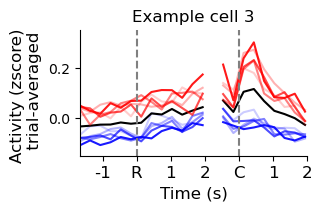

In [151]:
f,ax = plt.subplots(1,1, figsize = [3.5,2], tight_layout=False)
cell_id = 133; y_lim = [-.15,.35]; title_txt = 'Example cell 3'
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=1, left', alpha=0.9)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=2, left', alpha=0.7)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=3, left', alpha=0.5)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=4, left', alpha=0.3)
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=5, left', alpha=0.2)
ds_ready_windowed.isel(cell=cell_id).mean(dim='trial').plot(ax=ax,c='k',label='all trials')
(ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==-1)).mean(dim='trial')).plot(ax=ax,c='r',label='n=1, right', alpha=0.9)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=2, right', alpha=0.7)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=3, right', alpha=0.5)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=4, right', alpha=0.3)
ds_ready_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=5, right', alpha=0.2)

(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=1, left', alpha=0.9)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=2, left', alpha=0.7)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==1)).mean(dim='trial')).plot(ax=ax,c='b',label='n=3, left', alpha=0.5)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=4, left', alpha=0.3)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==1)).mean(dim='trial').plot(ax=ax,c='b',label='n=5, left', alpha=0.2)
ds_choice_windowed.isel(cell=cell_id).mean(dim='trial').plot(ax=ax,c='k',label='all trials')
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-1]==-1)).mean(dim='trial')).plot(ax=ax,c='r',label='n=1, right', alpha=0.9)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-2]==-1)).mean(dim='trial')).plot(ax=ax,c='r',label='n=2, right', alpha=0.7)
(ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-3]==-1)).mean(dim='trial')).plot(ax=ax,c='r',label='n=3, right', alpha=0.5)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-4]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=4, right', alpha=0.3)
ds_choice_windowed.isel(cell=cell_id, trial=(rc_hist[:,-5]==-1)).mean(dim='trial').plot(ax=ax,c='r',label='n=5, right', alpha=0.2)


ax.plot([0,0],[-1,1],'--',c='gray')
ax.plot([x_offset,x_offset],[-1,1],'--',c='gray')
ax.set_xlim([-50,150])
ax.set_ylim(y_lim)
ax.set_xticks([-30,0,30,60,x_offset,x_offset+30,x_offset+60])
ax.set_xticklabels([-1,'R',1,2,'C',1,2],fontsize=12)
ax.set_xlabel('Time (s)',fontsize=12)
ax.set_ylabel('Activity (zscore) \n trial-averaged',fontsize=12)
ax.set_title(title_txt,fontsize=12)
# ax.legend(loc='lower left',bbox_to_anchor = (0,1), ncol=4, frameon=False)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
f.subplots_adjust(left=.25, bottom=.25, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'2_cell','cell_example_{}.png'.format(cell_id)))
# f.savefig(pjoin(fig_save_dir,'2_cell','cell_example_{}.svg'.format(cell_id)))

## Rp1 Cell Fraction

In [39]:
crit_type = 0; sh_mean = .05
# crit_type = 1; sh_mean = 0
# crit_type = 2; sh_mean = .025
rsc_cf = calc_cell_frac('RSC', crit_type)
ppc_cf = calc_cell_frac('PPC', crit_type)
m2_cf = calc_cell_frac('M2', crit_type)
alm_cf = calc_cell_frac('ALM', crit_type)
s1_cf = calc_cell_frac('S1', crit_type)
cf_mean = np.array([np.mean(rsc_cf), np.mean(ppc_cf), np.mean(m2_cf), 
                    np.mean(alm_cf), np.mean(s1_cf)])
cf_sem = np.array([sem(rsc_cf), sem(ppc_cf), sem(m2_cf),
                   sem(alm_cf), sem(s1_cf)])

### [Plt] barplot fraction of Rp1 cells

n sessions: 15 16 17 12 14
mean: 0.20 0.27 0.16 0.18 0.17
sem: 0.02 0.03 0.01 0.02 0.03


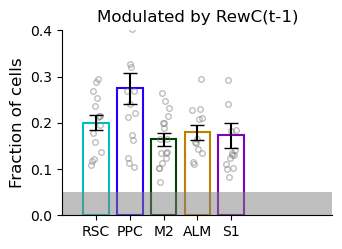

In [40]:
f,ax = plt.subplots(1,1, sharey=False, sharex=False, figsize = [4.5, 2.5],  tight_layout=False)
# ax.plot([0,14],[0,0],'--k',linewidth=1)
x_ind = [1,2,3,4,5]
ax.bar(x_ind[0],cf_mean[0],0.75,facecolor='w',edgecolor=plt_colors['RSC'],linewidth=1.5)
ax.bar(x_ind[1],cf_mean[1],0.75,facecolor='w',edgecolor=plt_colors['PPC'],linewidth=1.5)
ax.bar(x_ind[2],cf_mean[2],0.75,facecolor='w',edgecolor=plt_colors['M2'],linewidth=1.5)
ax.bar(x_ind[3],cf_mean[3],0.75,facecolor='w',edgecolor=plt_colors['ALM'],linewidth=1.5)
ax.bar(x_ind[4],cf_mean[4],0.75,facecolor='w',edgecolor=plt_colors['S1'],linewidth=1.5)

ax.plot(np.linspace(x_ind[0]-.15,x_ind[0]+.15,len(rsc_cf)), rsc_cf, 'o',
        markeredgecolor='grey', markerfacecolor='none', ms=4, alpha=.5)
ax.plot(np.linspace(x_ind[1]-.15,x_ind[1]+.15,len(ppc_cf)), ppc_cf, 'o',
        markeredgecolor='grey', markerfacecolor='none', ms=4, alpha=.5)
ax.plot(np.linspace(x_ind[2]-.15,x_ind[2]+.15,len(m2_cf)), m2_cf, 'o',
        markeredgecolor='grey', markerfacecolor='none', ms=4, alpha=.5)
ax.plot(np.linspace(x_ind[3]-.15,x_ind[3]+.15,len(alm_cf)), alm_cf, 'o',
        markeredgecolor='grey', markerfacecolor='none', ms=4, alpha=.5)
ax.plot(np.linspace(x_ind[4]-.15,x_ind[4]+.15,len(s1_cf)), s1_cf, 'o',
        markeredgecolor='grey', markerfacecolor='none', ms=4, alpha=.5)

ax.errorbar(x_ind,cf_mean,cf_sem,linestyle='none',c='k',capsize=5)
ax.fill_between([0,8],[sh_mean,sh_mean],[0,0],facecolor='grey',alpha=0.5)
ax.set_ylim([0,.4])
ax.set_xlim([0,8])
ax.set_ylabel('Fraction of cells',fontsize=12)
ax.set_title('Modulated by RewC(t-1)',fontsize=12)

ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['RSC','PPC','M2','ALM','S1'],fontsize=10)#rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print('n sessions: {0} {1} {2} {3} {4}'.format(len(rsc_cf), len(ppc_cf), len(m2_cf), len(alm_cf), len(s1_cf),))
print('mean: {0:.2f} {1:.2f} {2:.2f} {3:.2f} {4:.2f}'.format(*cf_mean))
print('sem: {0:.2f} {1:.2f} {2:.2f} {3:.2f} {4:.2f}'.format(*cf_sem))

f.subplots_adjust(left=.25, bottom=None, right=.85, top=.85, wspace=None, hspace=None)
f.savefig(pjoin(fig_save_dir,'2_cell','fraction_rp1_cells_crit_{}.png'.format(crit_type)))
f.savefig(pjoin(fig_save_dir,'2_cell','fraction_rp1_cells_crit_{}.svg'.format(crit_type)))

## Delta loglik cell models

In [41]:
crit_type = 3

sessions_all = BD.get_sessions('RSC')
rsc_ll_vec = np.array([])
for ss in range(len(sessions_all)):
    temp = get_lik_dif_session(sessions_all[ss], crit_type, 'hyp_r', 'exp_r')
    rsc_ll_vec = np.append(rsc_ll_vec, temp)

sessions_all = BD.get_sessions('PPC')
ppc_ll_vec = np.array([])
for ss in range(len(sessions_all)):
    temp = get_lik_dif_session(sessions_all[ss], crit_type, 'hyp_r', 'exp_r')
    ppc_ll_vec = np.append(ppc_ll_vec, temp)
    
sessions_all = BD.get_sessions('M2')
m2_ll_vec = np.array([])
for ss in range(len(sessions_all)):
    temp = get_lik_dif_session(sessions_all[ss], crit_type, 'hyp_r', 'exp_r')
    m2_ll_vec = np.append(m2_ll_vec, temp)
    
sessions_all = BD.get_sessions('ALM')
alm_ll_vec = np.array([])
for ss in range(len(sessions_all)):
    temp = get_lik_dif_session(sessions_all[ss], crit_type, 'hyp_r', 'exp_r')
    alm_ll_vec = np.append(alm_ll_vec, temp)
    
sessions_all = BD.get_sessions('S1')
s1_ll_vec = np.array([])
for ss in range(len(sessions_all)):
    temp = get_lik_dif_session(sessions_all[ss], crit_type, 'hyp_r', 'exp_r')
    s1_ll_vec = np.append(s1_ll_vec, temp)


In [42]:
# Get behavior data
files_savename = pjoin(behavior_dir,'behlogit_imaging_15_hist.pkl')
behlogit_expert = pickle.load(open(files_savename,'rb'))

real_15_ll = delta_loglik_func(behlogit_expert, behlogit_expert ,'hyp_r','exp_r',15)

### [Plt] boxplot loglik

wilcoxon
wilcoxon
wilcoxon
wilcoxon
wilcoxon
wilcoxon
Medians: -1.82e-03 -1.70e-03 -1.95e-03 -1.73e-03 -1.57e-03 4.28e-03
p values without multicompare are: 7.1e-124 6.2e-103 4.9e-74 6.1e-46 3.01e-39 4.38e-10
p values with FDR (BH) are: 4.3e-123 1.8e-102 9.9e-74 9.1e-46 4.38e-10
p values with bonferoni are: 4.3e-123 3.7e-102 3.0e-73 3.6e-45 2.63e-09


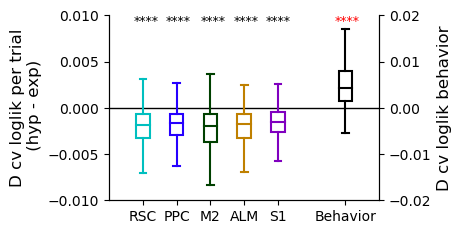

In [43]:
f,ax = plt.subplots(1,1, sharey=False, sharex=False, figsize = [4.5, 2.5],  tight_layout=False)
ax.plot([0,14],[0,0],'-k',linewidth=1)
plot_colored_boxplot(ax,rsc_ll_vec,1,plt_colors['RSC'])
plot_colored_boxplot(ax,ppc_ll_vec,2,plt_colors['PPC'])
plot_colored_boxplot(ax,m2_ll_vec,3,plt_colors['M2'])
plot_colored_boxplot(ax,alm_ll_vec,4,plt_colors['ALM'])
plot_colored_boxplot(ax,s1_ll_vec,5,plt_colors['S1'])

ax.set_ylim([-.010,.010])
ax.set_xlim([0,8])
# y_string = r'$\Delta$ cv loglik cells'
y_string = 'D cv loglik per trial'
y_string += '\n (hyp - exp)'
ax.set_ylabel(y_string,fontsize=12)

ax2=ax.twinx()
plot_colored_boxplot(ax2,real_15_ll,7,'k')

ax2.set_ylim([-.02,.02])
# ax2.set_yticks([-1,0,1])
# ax2.set_ylabel(r'$\Delta$ cv loglik behavior',fontsize=10)
ax2.set_ylabel('D cv loglik behavior',fontsize=12)

ax.set_xticks([1,2,3,4,5,7])
ax.set_xticklabels(['RSC','PPC','M2','ALM','S1', 'Behavior'],fontsize=10)#rotation=45)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
pval, sig_lvl, h_norm, pos_neg = stats_compare(rsc_ll_vec); pval_vec = pval
add_sig_plt(ax,.09,.95,9,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(ppc_ll_vec); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.21,.95,9,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(m2_ll_vec); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.34,.95,9,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(alm_ll_vec); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.46,.95,9,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(s1_ll_vec); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.58,.95,9,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(real_15_ll); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.835,.95,9,pval,sig_lvl,pos_neg)
medians_vec = [np.median(rsc_ll_vec), np.median(ppc_ll_vec), np.median(m2_ll_vec),
               np.median(alm_ll_vec), np.median(s1_ll_vec), np.median(real_15_ll),]
print('Medians: {0:.2e} {1:.2e} {2:.2e} {3:.2e} {4:.2e} {5:.2e}'.format(*medians_vec))
_,pval_fdr,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='fdr_bh')
_,pval_b,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='b')
print('p values without multicompare are: {0:.1e} {1:.1e} {2:.1e} {3:.1e} {4:.2e} {5:.2e}'.format(*pval_vec))
print('p values with FDR (BH) are: {0:.1e} {1:.1e} {2:.1e} {3:.1e} {5:.2e}'.format(*pval_fdr))
print('p values with bonferoni are: {0:.1e} {1:.1e} {2:.1e} {3:.1e} {5:.2e}'.format(*pval_b))

f.subplots_adjust(left=.25, bottom=None, right=.85, top=.85, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'2_cell','delta_loglik_cells_{}.png'.format(crit_type)))
# f.savefig(pjoin(fig_save_dir,'2_cell','delta_loglik_cells_{}.svg'.format(crit_type)))